WNixalo | 20181122

---

This notebook is an attempt to breach a score of 0.93 on the private leaderboard using ResNet34.

This notebook gets a pvt score of **0.92601** @ a threshold of 0.2.

In [3]:
__version__ # fastai

'1.0.28'

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Data

In [3]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True); #path

In [4]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [5]:
np.random.seed(0)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' '))
data = (src.transform(tfms, size=128)
       .databunch()
       .normalize(imagenet_stats))

In [6]:
arch = models.resnet34
acc_025 = partial(accuracy_thresh, thresh=0.25)
f_score = partial(fbeta, thresh=0.25)
learn   = create_cnn(data, arch, metrics=[acc_025, f_score])

## Training

### size 128 stage 1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


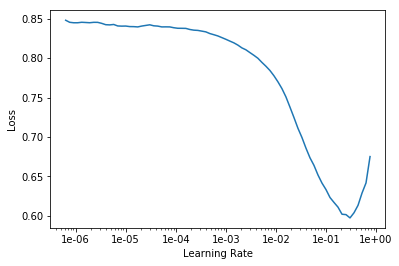

In [7]:
learn.lr_find(); learn.recorder.plot()

In [8]:
lr = 1e-2

In [9]:
learn.fit_one_cycle(6, slice(lr)) # oh cool: fastai by default uses slice(None, 0.003, None) for max_lr

Total time: 05:34
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.124664    0.109513    0.948632         0.898007  (01:00)
2      0.113934    0.101371    0.955267         0.910771  (00:54)
3      0.107862    0.097833    0.954641         0.914345  (00:54)
4      0.100178    0.090936    0.958965         0.920203  (00:54)
5      0.095792    0.087463    0.959685         0.923918  (00:54)
6      0.093099    0.087300    0.959954         0.923695  (00:54)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


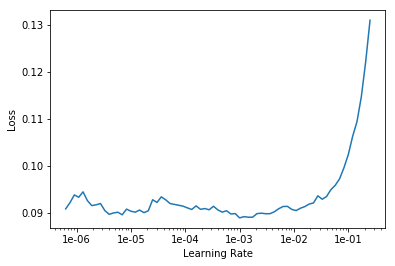

In [10]:
learn.lr_find(); learn.recorder.plot()

In [11]:
# learn.fit_one_cycle(6, slice(lr/10)) 

In [14]:
learn.save('planet-rn34-sz128-stg1')

### size 128 stage 2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


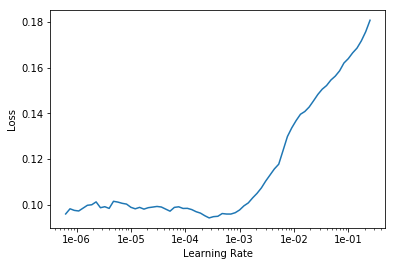

In [15]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [16]:
learn.fit_one_cycle(6, slice(1e-5, lr/5))

Total time: 07:50
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.095244    0.091998    0.957962         0.918493  (01:17)
2      0.097617    0.091029    0.958137         0.920181  (01:18)
3      0.092538    0.088245    0.960978         0.922228  (01:18)
4      0.089126    0.086069    0.961087         0.924255  (01:18)
5      0.087359    0.083599    0.961886         0.926858  (01:18)
6      0.084095    0.083736    0.962882         0.926369  (01:18)



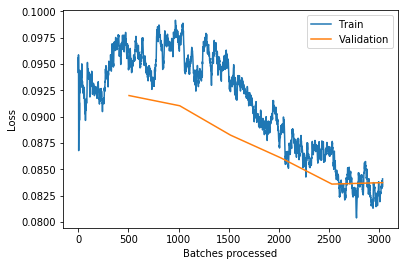

In [17]:
learn.recorder.plot_losses()

In [18]:
learn.save('planet-rn34-sz128-stg2')

a 2nd training cycle didn't improve. trying with weight decay of 0.001 decreased val_loss by 0.0004 and increased fbeta by 0.0003. Ehh.

### size 256 stage 1

In [19]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


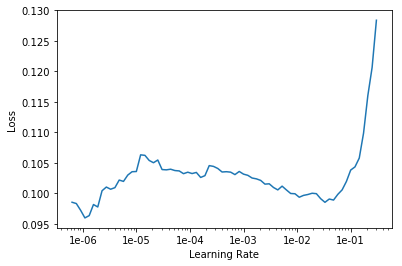

In [20]:
learn.freeze()
learn.lr_find(); learn.recorder.plot()

In [21]:
lr = 5e-3 # 1e-2/2

In [22]:
learn.fit_one_cycle(6, slice(lr))

Total time: 18:05
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.087618    0.085499    0.963071         0.925262  (03:00)
2      0.089841    0.084039    0.960986         0.925125  (03:00)
3      0.088128    0.082953    0.960353         0.926969  (03:01)
4      0.084338    0.082532    0.962635         0.927372  (03:00)
5      0.081655    0.081754    0.963601         0.928366  (03:00)
6      0.082452    0.081304    0.962613         0.928696  (03:01)



In [23]:
learn.save('planet-rn34-sz256-stg1')

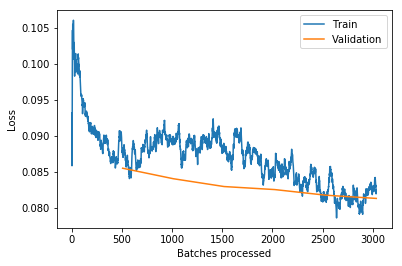

In [24]:
learn.recorder.plot_losses()

training further at lr=1e-3 improved val_loss by 9.3e-5, accuracy_thresh by 7.3e-4, and fbeta by -1.3e-4 (worse). ehh.

### size 256 stage 2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


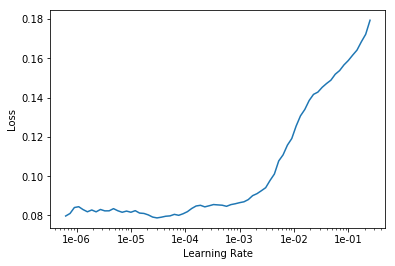

In [25]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [26]:
lr = 1e-3

In [27]:
learn.fit_one_cycle(6, slice(1e-5, lr/5))

Total time: 24:32
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.081349    0.082229    0.962613         0.927661  (04:05)
2      0.083200    0.082995    0.962570         0.926456  (04:05)
3      0.082936    0.081912    0.963761         0.928450  (04:05)
4      0.083163    0.081407    0.963805         0.928382  (04:05)
5      0.079738    0.080824    0.964059         0.929187  (04:05)
6      0.076459    0.080886    0.964379         0.929328  (04:05)



In [28]:
learn.save('planet-rn34-sz256-stg2')

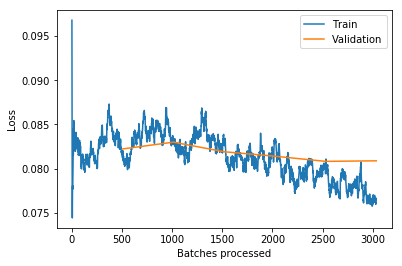

In [29]:
learn.recorder.plot_losses()

training further with lr / 2 gave valid_loss: 1.2e-3 worse, acc_thresh: 7.6e-4 better, fbeta: 7.2e-4 worse. Ehh.

I have this hunch, that further finetuning early on may actually hurt the final state of the model, because it narrows the search space by bringing the training loss down so quickly. Any further training or finetuning later on leads to overfitting much quicker than if that early extra finetuning hadn't been done. *hmmmm*. Refreezing the first conv layer group and training further didn't really help the model.

## Predictions

In [9]:
learn.load('planet-rn34-sz256-stg2');

In [30]:
subm_df = pd.read_csv(path/'sample_submission_v2.csv')
subdic = {c1:c2 for c1,c2 in zip(subm_df.image_name,subm_df.tags)}

In [31]:
def set_test_datafolder(learner, test_folder):
    learner.data = (src.add_test_folder(test_folder)
                    .transform(tfms, size=256)
                    .databunch().normalize(imagenet_stats))

1st testset portion

In [32]:
set_test_datafolder(learn, 'test-jpg')
fnames = [f.name.split('.')[0] for f in learn.data.test_ds.x.items]

In [33]:
preds1 = learn.TTA(ds_type=DatasetType.Test)

Total time: 12:08



2nd testset portion

In [34]:
set_test_datafolder(learn, 'test-jpg-additional')
fnames.extend([f.name.split('.')[0] for f in learn.data.test_ds.x.items])

In [35]:
preds2 = learn.TTA(ds_type=DatasetType.Test)

Total time: 06:12



In [36]:
preds = (torch.cat((preds1[0],preds2[0])), torch.cat((preds1[1],preds2[1])))

saving results to disk

In [37]:
torch.save(preds, f'planet-rn34-sz256-stg2-normalnotebooktrain.pkl')

In [13]:
preds = torch.load(f'planet-rn34-sz256-stg2.pkl')

## Submissions

In [38]:
import datetime
date = str(datetime.date.today()).replace('-','')

In [18]:
# learn.data.c2i

In [19]:
# learn.data.c2i.items()

In [39]:
idx2class = {v:k for k,v in learn.data.c2i.items()}

In [21]:
# idx2class

In [49]:
th = 0.15

for i,fn in enumerate(fnames):
    subdic[fn] = ' '.join(idx2class[cdx] for cdx in np.where(preds[0][i]>=th)[0])
    
subm_col = [subdic[fn] for fn in subm_df.image_name]
subm_df.tags = subm_col

In [50]:
sub_msg = f"fastai {__version__}; rn34 2-stg; thresh:{th}; {date}"

In [51]:
sub_name = f'planet-rn34-sz256-stg2_{date}_th{str(th).replace(".","")}.csv'
subm_df.to_csv(path/'submissions/'/sub_name, index=False, )
! kaggle competitions submit -c planet-understanding-the-amazon-from-space -f {path}/submissions/{sub_name} -m "{sub_msg}"

100%|██████████████████████████████████████| 2.33M/2.33M [00:01<00:00, 1.76MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

```
th=0.3:  0.92206
th=0.2:  0.92601
th=0.25: 0.92546
th=0.15: 0.92329
```

final scores: 
- accuray_threshold(0.25): 0.964379
- fbeta: 0.929328

## end